# Human-Readable Precision-Recall curve construction procedure - (Pascal VOC 2012)
## Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions

In [2]:
def unnormalize_coords(img, coords):
    x = int(coords[0] * img.shape[1])
    y = int(coords[1] * img.shape[0])
    w = int(coords[2] * img.shape[1])
    h = int(coords[3] * img.shape[0])
    return [x, y, w, h]

In [3]:
def to_dataset(imgs_path, ann_path, is_det=False, unnormalize=False):
    imgs_list = [img for img in os.listdir(imgs_path) if img.endswith('.png') or img.endswith('.jpg')] 
    ann_list = [ann for ann in os.listdir(ann_path) if ann.endswith('.txt')]
    annotations = []
    for ann in ann_list:
        ann_file_path = os.path.join(ann_path, ann)
        ann_file = open(ann_file_path, 'r')
        for line in ann_file:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            line = line.split(" ")
            line = [float(w) for w in line] 
            coords = line[-4:]

            if unnormalize:
                img_name = os.path.splitext(ann)[0] + '.jpg'
                if img_name not in imgs_list:
                    img_name = os.path.splitext(ann)[0] + '.png'
                img_path = os.path.join(imgs_path, img_name)
                img = cv2.imread(img_path)
                new_coords = unnormalize_coords(img, coords)
                line.append(new_coords)

            line.insert(0, os.path.splitext(ann)[0])
            annotations.append(line) 
        ann_file.close()
    columns = ['image', 'label', 'x_norm', 'y_norm', 'w_norm', 'h_norm']
    if unnormalize:
        columns.extend(['xywh'])
    if is_det:
        columns.insert(2, 'score')
    ann_df = pd.DataFrame(annotations, columns=columns)
    return ann_df

In [4]:
def get_iou(a, b, epsilon=1e-5):
    
    a = [a[0], a[1], a[0] + a[2], a[1] + a[3]]
    b = [b[0], b[1], b[0] + b[2], b[1] + b[3]]

    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    width = (x2 - x1)
    height = (y2 - y1)

    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    iou = area_overlap / (area_combined+epsilon)
    return iou

In [5]:
def calculate_AP(rec, prec):
    mrec = []
    mrec.append(0)
    [mrec.append(e) for e in rec]
    mrec.append(1)
    mpre = []
    mpre.append(0)
    [mpre.append(e) for e in prec]
    mpre.append(0)
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])
    ii = []
    for i in range(len(mrec) - 1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i + 1)
    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
    return ap


In [6]:
def calculate_recall_precision_AP(ann_df, det_df, labels):
    _ann_df = ann_df.copy(deep=True)
    _det_df = det_df.copy(deep=True)
    ret = []

    for l in labels:
        ann_labels = _ann_df[_ann_df['label'] == l]
        ann_labels.reset_index(inplace=True, drop=True)
        ann_labels['seen'] = [0 for _ in range(ann_labels.shape[0])]
        det_labels = _det_df[_det_df['label'] == l]
        
        npos = ann_labels.shape[0]
        TP = np.zeros(det_labels.shape[0])
        FP = np.zeros(det_labels.shape[0])
        
        det_labels = det_labels.sort_values(by=['score'], ascending=False)
        det_labels.reset_index(inplace=True, drop=True)
        
        for i, pred in det_labels.iterrows():
            pred['image']
            only_img_ann = ann_labels[ann_labels['image'] == pred['image']]
            only_img_ann = only_img_ann[only_img_ann['seen'] == 0]
                
            max_iou_found = 0 
            for j, ann in only_img_ann.iterrows():
                iou = get_iou(pred['xywh'], ann['xywh'])
                if iou > max_iou_found:
                    max_iou_found = iou
                    ann_seen = j

            if max_iou_found >= IOU_THR:
                TP[i] = 1
                ann_labels.loc[ann_seen, 'seen'] = 1
            else:
                FP[i] = 1
        
        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))
        ap = calculate_AP(rec, prec)
        r = {
            'class': l,
            'precision': prec,
            'recall': rec,
            'AP': ap * 100,
            'total TP': np.sum(TP),
            'total FP': np.sum(FP)
        }
        ret.append(r)
    return ret

In [7]:
def plot(ret):
    for rs in ret:
        plt.figure(figsize=[15, 10])
        plt.plot(rs['recall'], rs['precision'])
        plt.title('class: {} | AP: {:.2f}%'.format(rs['class'], rs['AP']))
        plt.xlabel('recall')
        plt.ylabel('precision')
        

## Upload dataset

In [8]:
IMGS_PATH = 'path/to/imges/folder/'
ANN_PATH = 'path/to/annotations/folder/'
DET_PATH = 'path/to/detections/folder'

IOU_THR = 0.3

In [9]:
ann_df = to_dataset(IMGS_PATH, ANN_PATH, unnormalize=True)
ann_df.head(5)

,image,label,x_norm,y_norm,w_norm,h_norm,xywh
0,new_158,0.0,0.202338,0.361112,0.603801,0.590643,"[121, 216, 362, 354]"
1,196,0.0,0.158480,0.407895,0.538012,0.548246,"[95, 244, 322, 328]"
2,45,0.0,0.155556,0.361112,0.605263,0.581871,"[93, 216, 363, 349]"
3,new_216,0.0,0.187719,0.486842,0.592105,0.502924,"[112, 292, 355, 301]"
4,28_b1093556-838c-4b45-8778-21eb76916316,0.0,0.071000,0.257500,0.048000,0.087000,"[45, 123, 30, 41]"


In [10]:
det_df = to_dataset(IMGS_PATH, DET_PATH, is_det=True, unnormalize=True)
det_df.head(5)

,image,label,score,x_norm,y_norm,w_norm,h_norm,xywh
0,new_158,0.0,0.793515,0.120000,0.205000,0.643333,0.773333,"[72, 122, 386, 464]"
1,new_158,0.0,0.146103,0.160000,0.308333,0.338333,0.561667,"[96, 185, 203, 337]"
2,196,0.0,0.982109,0.123333,0.320000,0.598333,0.645000,"[74, 192, 359, 387]"
3,45,0.0,0.881024,0.173333,0.005000,0.730000,0.928333,"[104, 3, 438, 557]"
4,45,0.0,0.535833,0.158333,0.256667,0.393333,0.685000,"[95, 154, 236, 411]"


In [11]:
# Pass to last argument a list of labels, in this case only one label is used "0"
ret = calculate_recall_precision_AP(ann_df, det_df, [0])

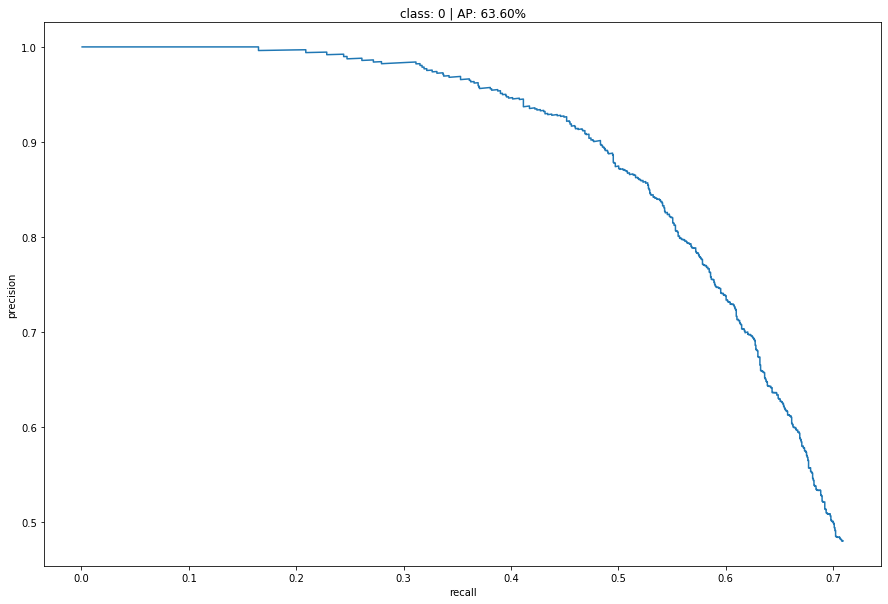

In [12]:
plot(ret)